In [4]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import time
import sys
import string
import lxml
import datetime
from datetime import date, timedelta

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve


In [480]:
lr = LogisticRegression()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=3000)

### Internal functions for parsing data from Lenta.ru web-site

In [1]:
    
    #Main link for one news rubric    
    def getMainURL(rubric):
        main_url = str('https://lenta.ru/rubrics/' + str(rubric) +'/')
        return main_url
    
    
    
    #Function for colllecting dates in certain interval of time in one list 
    def collectDates(startday, startmonth, startyear, endday, endmonth, endyear): 
        
        d1 = date(startyear, startmonth, startday)  # start date
        d2 = date(endyear, endmonth, endday)  # end date
        delta = d2 - d1         # timedelta

        datelist = [str(d1 + timedelta(days=x)) for x in range((d2-d1).days + 1)] #list of dates

        #formating date to the suitable form
        for i in range(delta.days + 1):
            datelist[i] = datelist[i].replace('-','/')
        return datelist
            
            
       
        
        
    #Collecting links for all news published on a certain date       
    def getDay(date):
        news_page_c = requests.get(str(main_url + date))
        news_page_c = news_page_c.content
        news_page_c = BeautifulSoup(news_page_c, 'lxml')
        links_day = [str('https://lenta.ru' + re.split('"', str(newshead))[1]) for newshead in news_page_c.findAll('h3', attrs = {'class':""})]
        return(links_day)
    
    
    # Collecting all words used in a certain article
    def getArticle(articlelink):
    
            #getting text 
        article_page = requests.get(articlelink)
        article_page = article_page.content
        article_page = BeautifulSoup(article_page, 'lxml')

        doc_text = article_page.find('div', attrs = {'class':'b-text clearfix js-topic__text'}) #Getting the text as one string
        doc_text = re.sub('<[^<]+?>', ' ', str(doc_text)) #removing all hashes, html features, etc
        doc_text = re.sub('['+string.punctuation+'—'+'«»'']', '', str(doc_text)) #removing punctuation


            #creating a single dataframe
        doc_text_pd = pd.Series(re.split(' ', doc_text)).str.lower()
    
        return (pd.DataFrame(doc_text_pd.value_counts()).transpose())
    
    
    #Creating a single dataframe of all words in all articles published in one day
    def getDayNews(date):
        listlinks = getDay(date)
        words = getArticle(listlinks[0])
        for i in range(1,len(listlinks)):
            try:
                words = pd.merge(words, getArticle(listlinks[i]), 'outer')   
            except:
                print('Something wrong with ' + str(listlinks[i]))
        words = words.fillna(0)
        words = pd.DataFrame(words.sum(0)).transpose()
        words.drop('', axis = 1, inplace= True)
        return words
    
    # Creating a final dataframe of all words used in a cetain period of time in news articles
    def GetFinal(dates):
        final = getDayNews(dates[0])
        for i in range(1, len(dates)):
            try:
                final = pd.merge(final, getDayNews(dates[i]), 'outer')
                print('I am working on ' + str(dates[i]))
            except:
                print('Something wrong with ' + str(dates[i]))
        final = final.fillna(0)
        return final


### For period from 12/5/2016 till 12/5/2017 articles from 'world' category of Lenta.ru were collected in a single dataframe. 

##### Creating a class for data processing and using different binary choice models to explain changes of currency exchange rate.

In [479]:
class BCModels():
    
    def __init__(self, textDF):
        self.textDF = textDF
        
    #Deleting words that appear too often or too rare
    def StopRare(self, textDF, stop, rare):
        self.stop = stop #percentage of observations, used as a stop benchmark
        self.rare = rare #percentage of observations, used as a rare benchmark
        
        matrixofwords = np.array(textDF)
        
        stopnum = stop*len(textDF.shape[0])
        rarenum = rare*len(textDF.shape[0])
        words = textDF.shape[1]
        
        Listofcol = []
        for i in range(words):
            counts = np.count_nonzero(matrixofwords[:,i])
            if (counts > stopnum) or (counts < rarenum):
                Listofcol.append(textDF.columns[i])
        textDF = textDF.drop(Listofcol, axis = 1)
        try: 
            textDF = textDF.set_index('Date')
            return textDF
        except:
            return textDF
    
    # Reformating the column of values of USD-RUB exchange rate to binary form 
    #(0 - decrease, 1 - increase, compared to previous day)
    def usdrubbin(self, usdrub):
        self.usdrub = usdrub
        usdrubbin = []
        numobs = usdrub.shape[1]
        
        for i in range(numobs):
            if usdrub[i+1] > usdrub[i]:
                usdrubbin.append(1)
            else:
                usdrubbin.append(0)
        usdrubbin = pd.DataFrame(usdrubbin, columns=['USDRUB'])
        return usdrubbin
    
    #creating a full data set
    def uniteDF(self, textDF, usdrubbin):
        self.textDF = textDF
        self.usdrubbin = usdrubbin
        textDF = textDF.join(usdrubbin, how = 'left')
        textDF = textDF.fillna(method='ffill')
        return textDF
    
    #random selection of train and test samples
    
    def trainsplit(self, textDF, testsize, randomstate = None):
        self.textDF = textDF
        self.testsize = testsize
        self.randomstate = randomstate
        
        cols = textDF.columns.tolist()
        
        Xtr, Xval, ytr, yval = train_test_split(
            textDF[cols[:-1]], textDF['USDRUB'],
            random_state=randomstate, test_size=testsize)
        print('There is ' + str(Xtr.shape[0]) + ' observations in training set, and ' + str(Xval.shape[0]) + ' in testing dataset')
        return Xtr, Xval, ytr, yval
    
    def modelCheck(self, Xtr, Xval, ytr, yval, function):
        self.Xtr = Xtr
        self.Xval = Xval
        self.ytr = ytr
        self.yval = yval
        self.function = function 
        
        plt.figure(figsize=(10, 10))
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        function.fit(Xtr, ytr)
        
        if function == lr:
            name = 'Logistic'
        elif function == svc:
            name = 'Support Vector Classification'
        elif function == rfc:
            name = 'Random Forest'
    
        rt_lm = LogisticRegression()
        pipeline = make_pipeline(rt, rt_lm)
        pipeline.fit(X_train, y_train)
        y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
        fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
        
        print('ROC_AUC score is ' + str(roc_auc_score(yval, function.predict(Xval))))
        
        #Comparison calibration of all models
        
        def calibration(self, Xtr, Xval, ytr, yval):
            self.Xtr = Xtr
            self.Xval = Xval
            self.ytr = ytr
            self.yval = yval

            plt.figure(figsize=(10, 10))
            ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
            ax2 = plt.subplot2grid((3, 1), (2, 0))

            ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
            for clf, name in [(lr, 'Logistic'),
                              (svc, 'Support Vector Classification'),
                              (rfc, 'Random Forest')]:
                clf.fit(X_train, y_train)
                if hasattr(clf, "predict_proba"):
                    prob_pos = clf.predict_proba(X_test)[:, 1]
                else:  # use decision function
                    prob_pos = clf.decision_function(X_test)
                    prob_pos = \
                        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
                fraction_of_positives, mean_predicted_value = \
                    calibration_curve(y_test, prob_pos, n_bins=10)

                ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                         label="%s" % (name, ))

                ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                         histtype="step", lw=2)

            ax1.set_ylabel("Fraction of positives")
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc="lower right")
            ax1.set_title('Calibration plots  (reliability curve)')

            ax2.set_xlabel("Mean predicted value")
            ax2.set_ylabel("Count")
            ax2.legend(loc="upper center", ncol=2)

            plt.tight_layout()
            plt.show()


##### List of dates, used for data collection

In [5]:
datelist = collectDates(12, 5, 2016, 12, 5, 2017)

In [258]:
# Dataframe of all collected words
LentaWords = pd.read_csv('D:/WorK Hard/ICEF/LentaWorld.csv', encoding='cp1251', index_col='Date')
LentaWords.drop('Unnamed: 0', axis = 1, inplace= True)

In [477]:
LentaWords.shape

(366, 117115)

In [ ]:
# There were 117115 different words identified in all articles

#### Let's remove words that occur too often (>90% days) or too rare (<5% days)

In [284]:
BM = BCModels(LentaWords)

In [288]:
LentaSR = BM.StopRare(LentaWords, 0.9, 0.05)

In [478]:
LentaSR.shape

(366, 10590)

In [295]:
# Now there are only 10590 words

#### Let's now add a column of changes in USDRUB exchange rate

In [96]:
USDRUBbin = pd.read_csv('D:/WorK Hard/ICEF/USDRUBbin.csv',encoding='cp1251', index_col='DATE')

In [305]:
BM = BCModels(LentaSR)

In [302]:
DataSet = BM.uniteDF(LentaSR, USDRUBbin)

In [307]:
BM = BCModels(DataSet)

#### From the whole dataset let's randomly choose training and valuation (testing) sets. 

In [313]:
Xtr, Xval, ytr, yval = BM.trainsplit(DataSet, 0.2)

There is 292 observations in training set, and 74 in testing dataset


#### Now there is enough information for testing different models. There will be tested three different models: logistic regression, support vector machine and random forest. For every model, quality will be estimated with ROC_AUC score and calibration curves will be plotted. 

ROC_AUC score is 0.611801242236


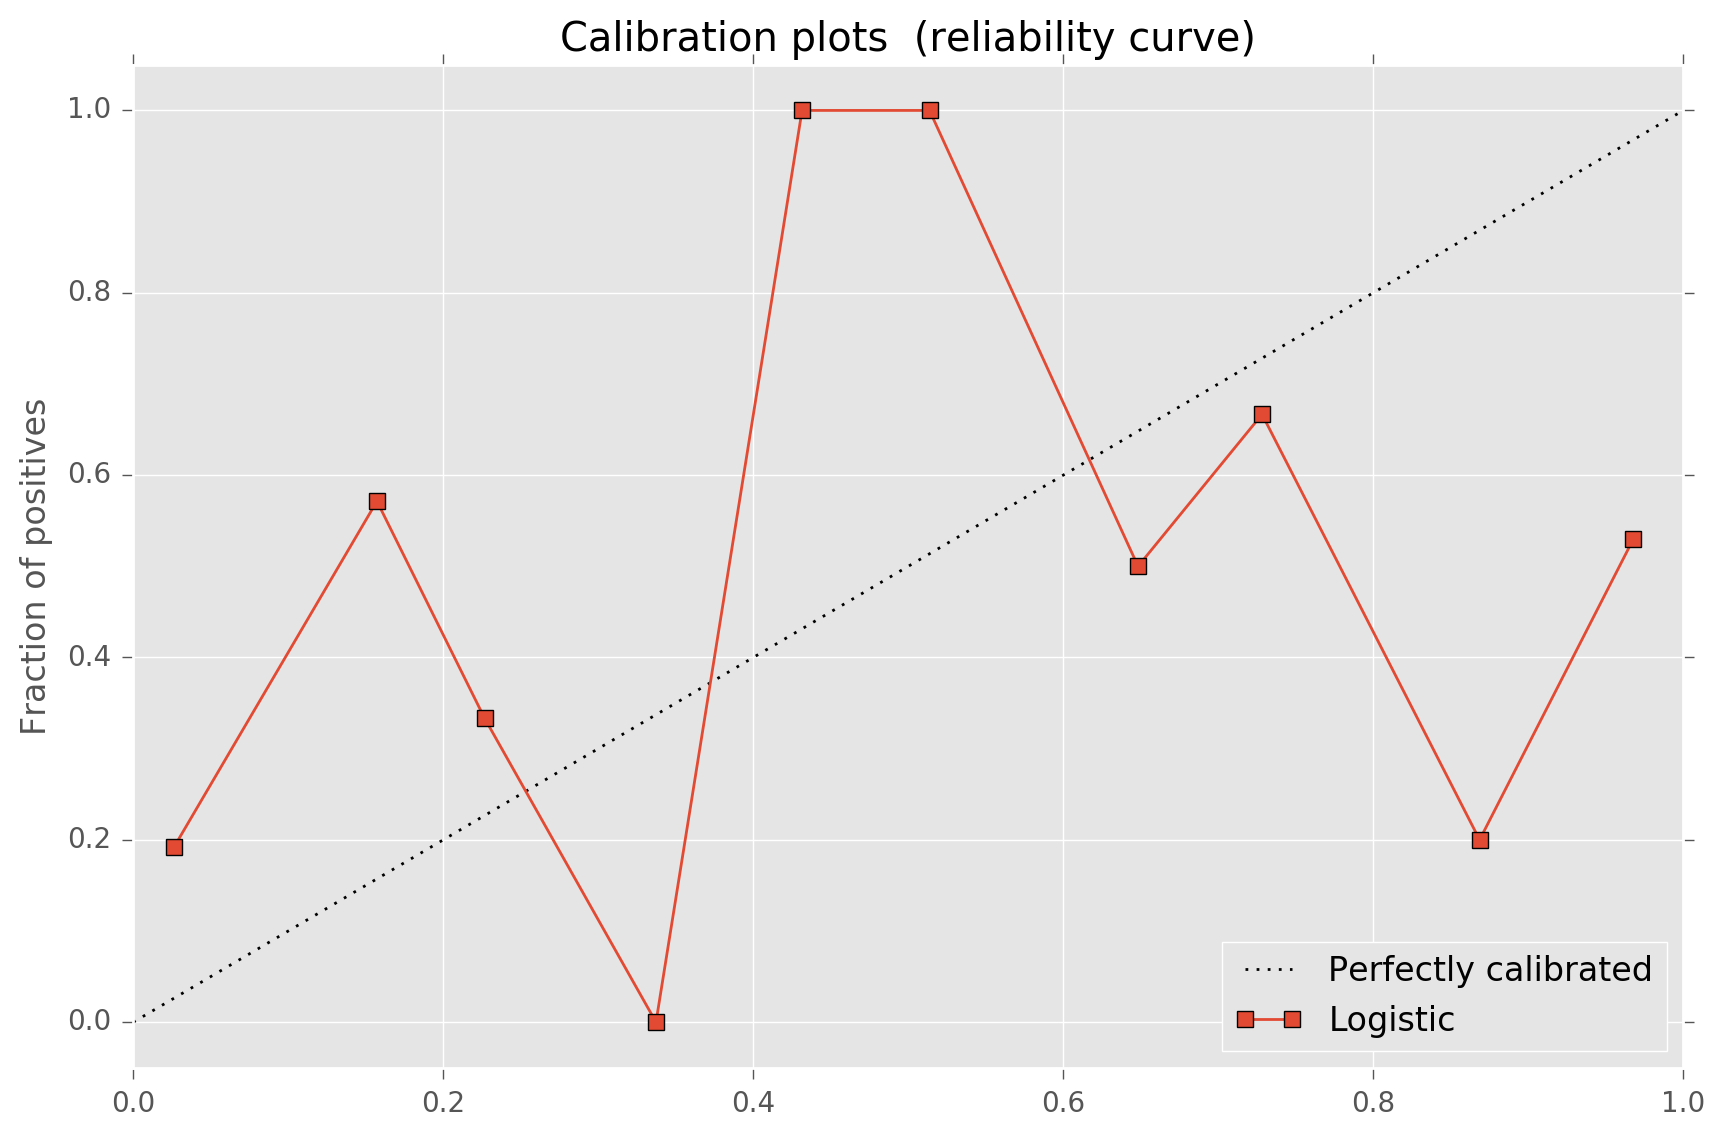

In [314]:
#Logistic regression
BM.modelCheck(Xtr, Xval, ytr, yval, lr)

ROC_AUC score is 0.629658385093


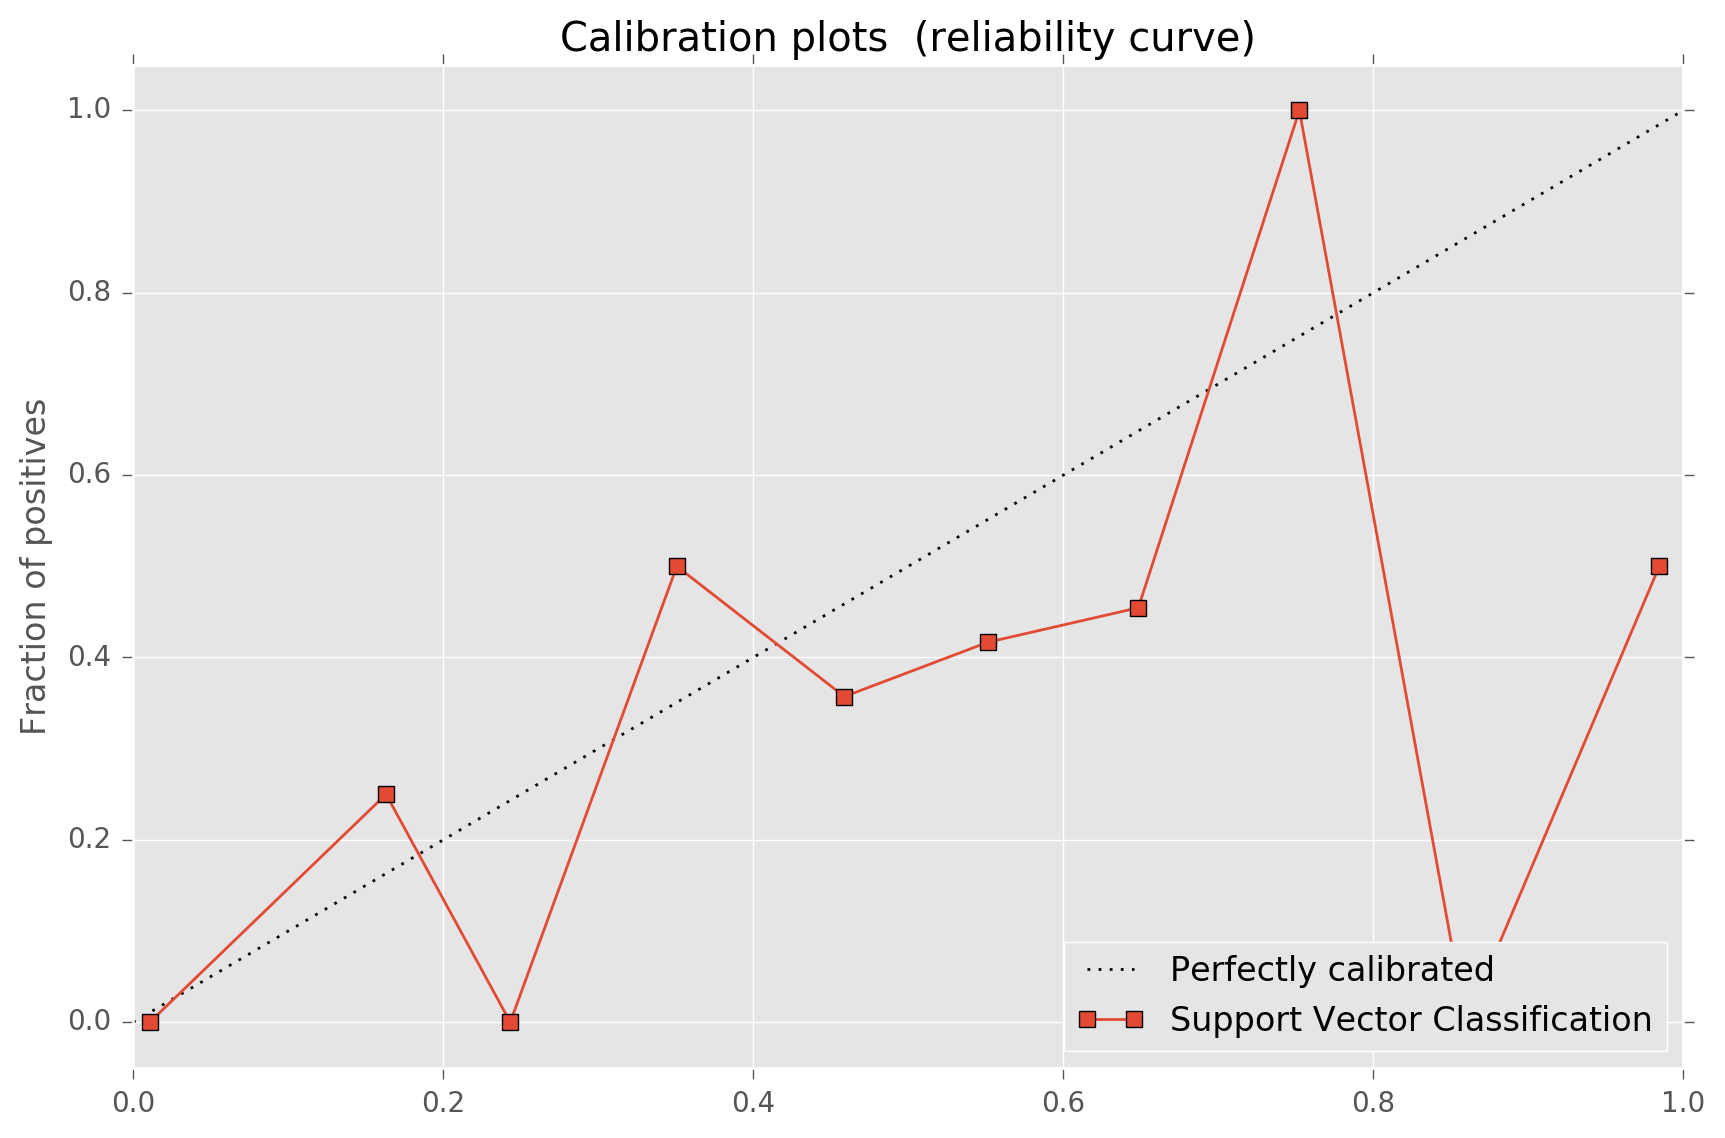

In [315]:
# Support Vector machine
BM.modelCheck(Xtr, Xval, ytr, yval, svc)

ROC_AUC score is 0.526397515528


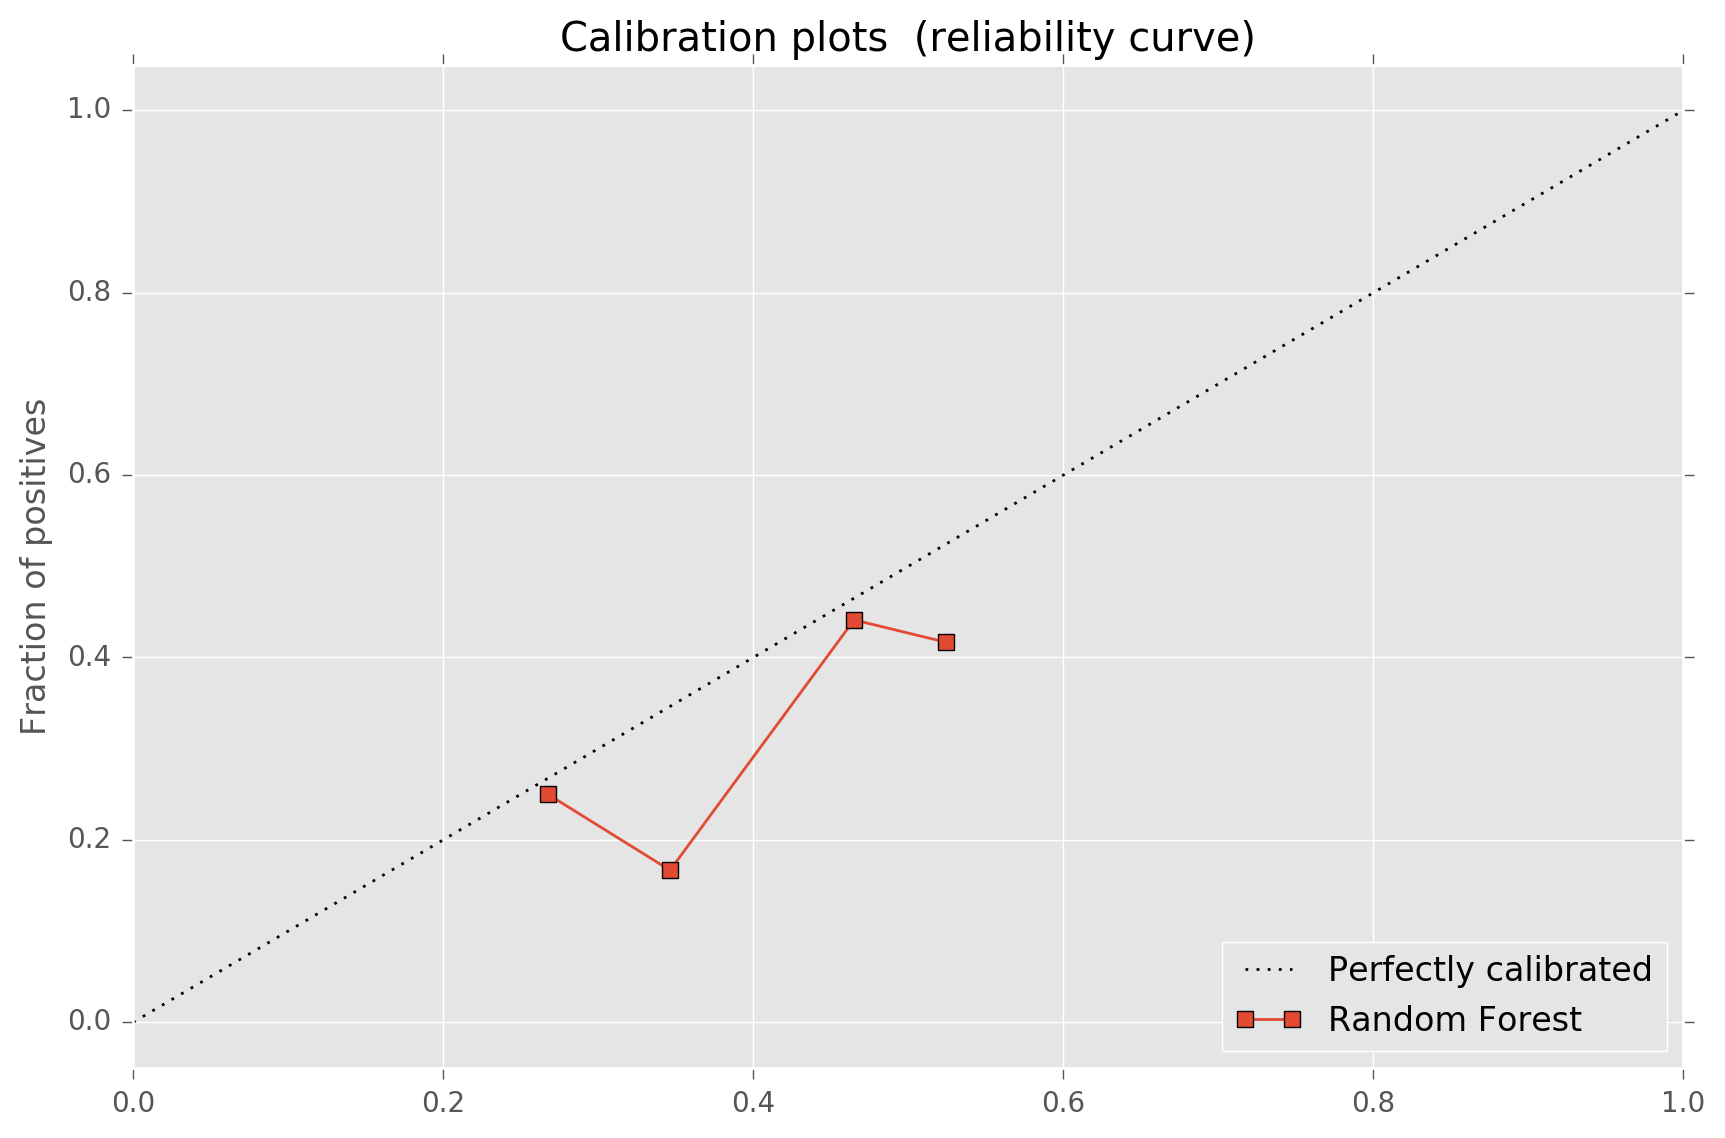

In [482]:
# Random Forest
BM.modelCheck(Xtr, Xval, ytr, yval, rfc)

### Further experiment for larger dataset.

In [342]:
datelistex = collectDates(12, 1, 2016, 11, 5, 2016)

In [ ]:
NewData = GetFinal(datelistex)

In [373]:
NewData.to_csv('D:/WorK Hard/ICEF/NewData.csv')

In [366]:
NewData['Date'] = pd.Series(datelistex)

In [370]:
NewData.set_index('Date', inplace= True)

In [472]:
NewData.shape

(121, 67197)

In [376]:
BM = BCModels(NewData)

In [377]:
NewDataSR = BM.StopRare(NewData, datelistex, 0.9, 0.05)

In [381]:
NewDataSR.shape

(121, 10568)

In [382]:
MoreData = pd.merge(LentaSR, NewDataSR, 'outer')

In [383]:
MoreData.shape

(487, 12905)

In [388]:
USDRUBmore = pd.read_csv('D:/WorK Hard/ICEF/USDMORE.csv', encoding='cp1251')

In [393]:
USDBC = BCModels(USDRUBmore)

In [394]:
USDRUBbinMore = USDBC.usdrubbin(USDRUBmore['<CLOSE>'])

In [384]:
BMex =BCModels(MoreData)

In [395]:
MoreDataFin = BMex.uniteDF(MoreData, USDRUBbinMore)

In [401]:
BMex = BCModels(MoreDataFin)

In [400]:
MoreDataFin.fillna(0, inplace=True)

In [403]:
Xtrex, Xvalex, ytrex, yvalex = BMex.trainsplit(MoreDataFin, 0.2)

There is 389 observations in training set, and 98 in testing dataset


ROC_AUC score is 0.705627705628


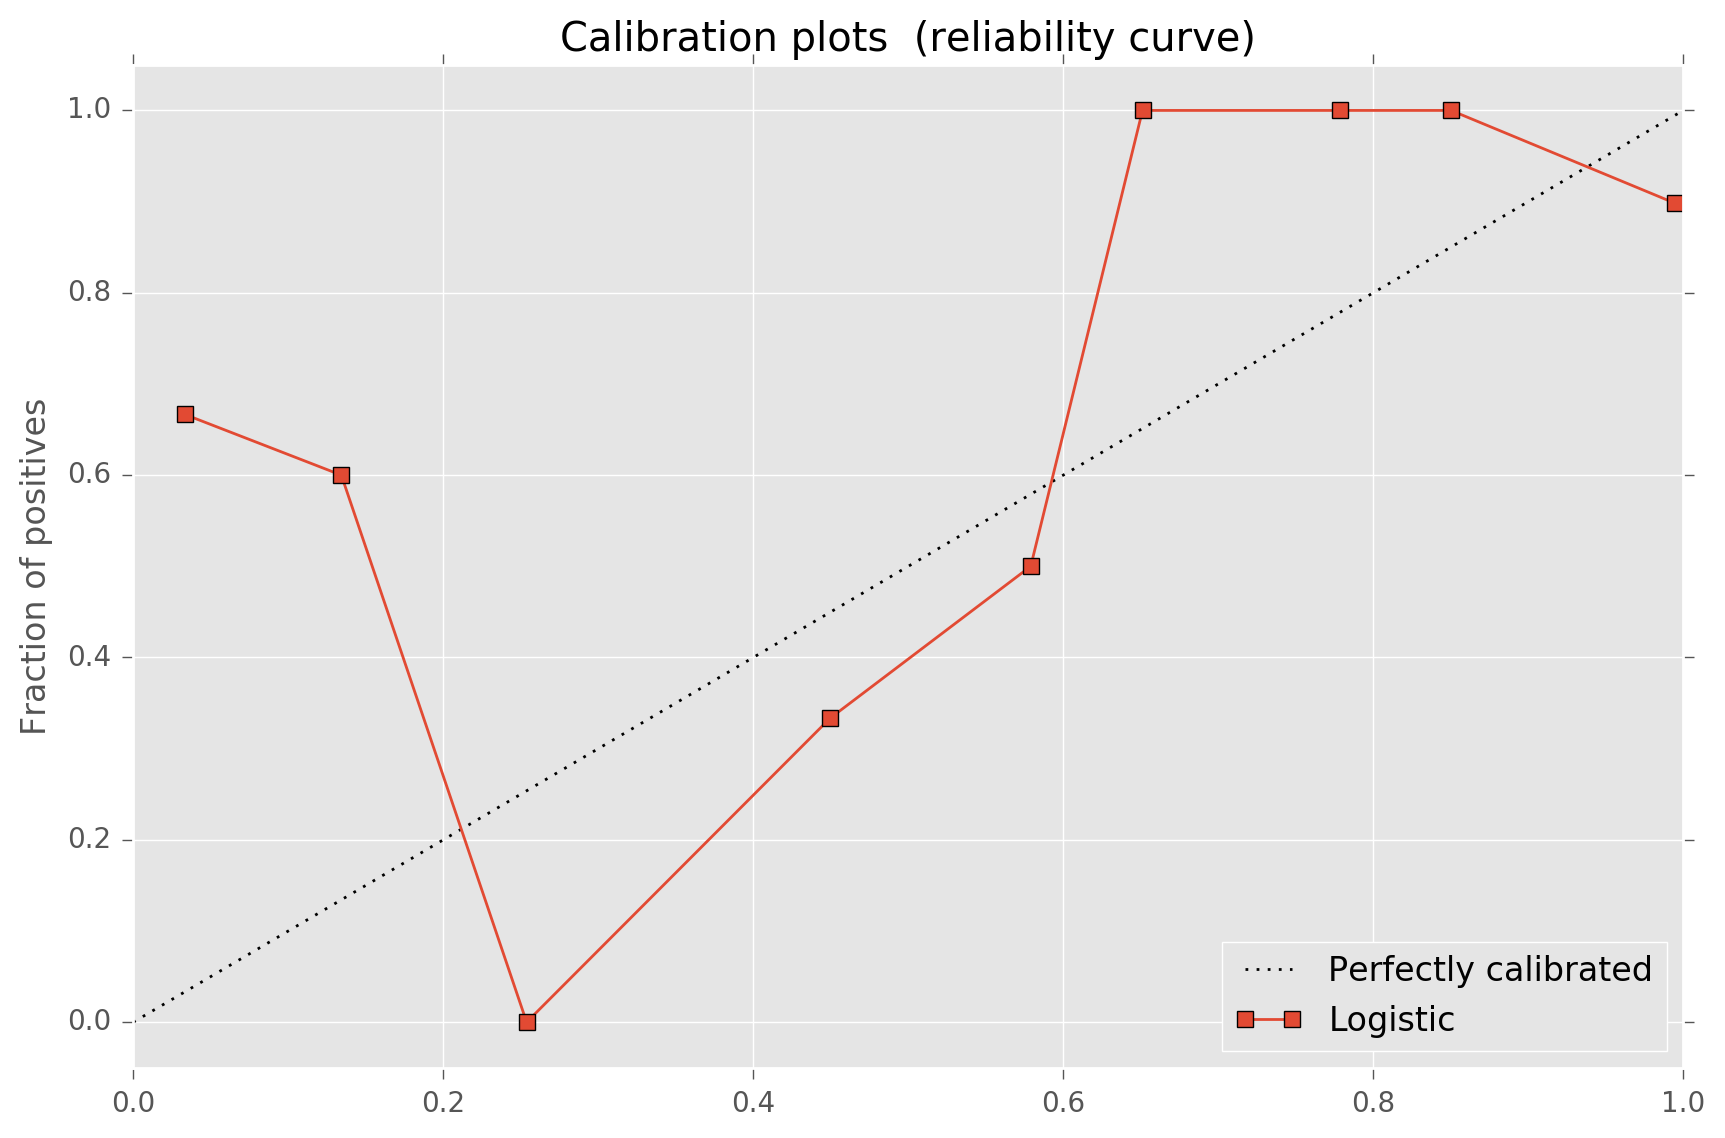

In [404]:
#Logistic regression
BM.modelCheck(Xtrex, Xvalex, ytrex, yvalex, lr)

ROC_AUC score is 0.699134199134


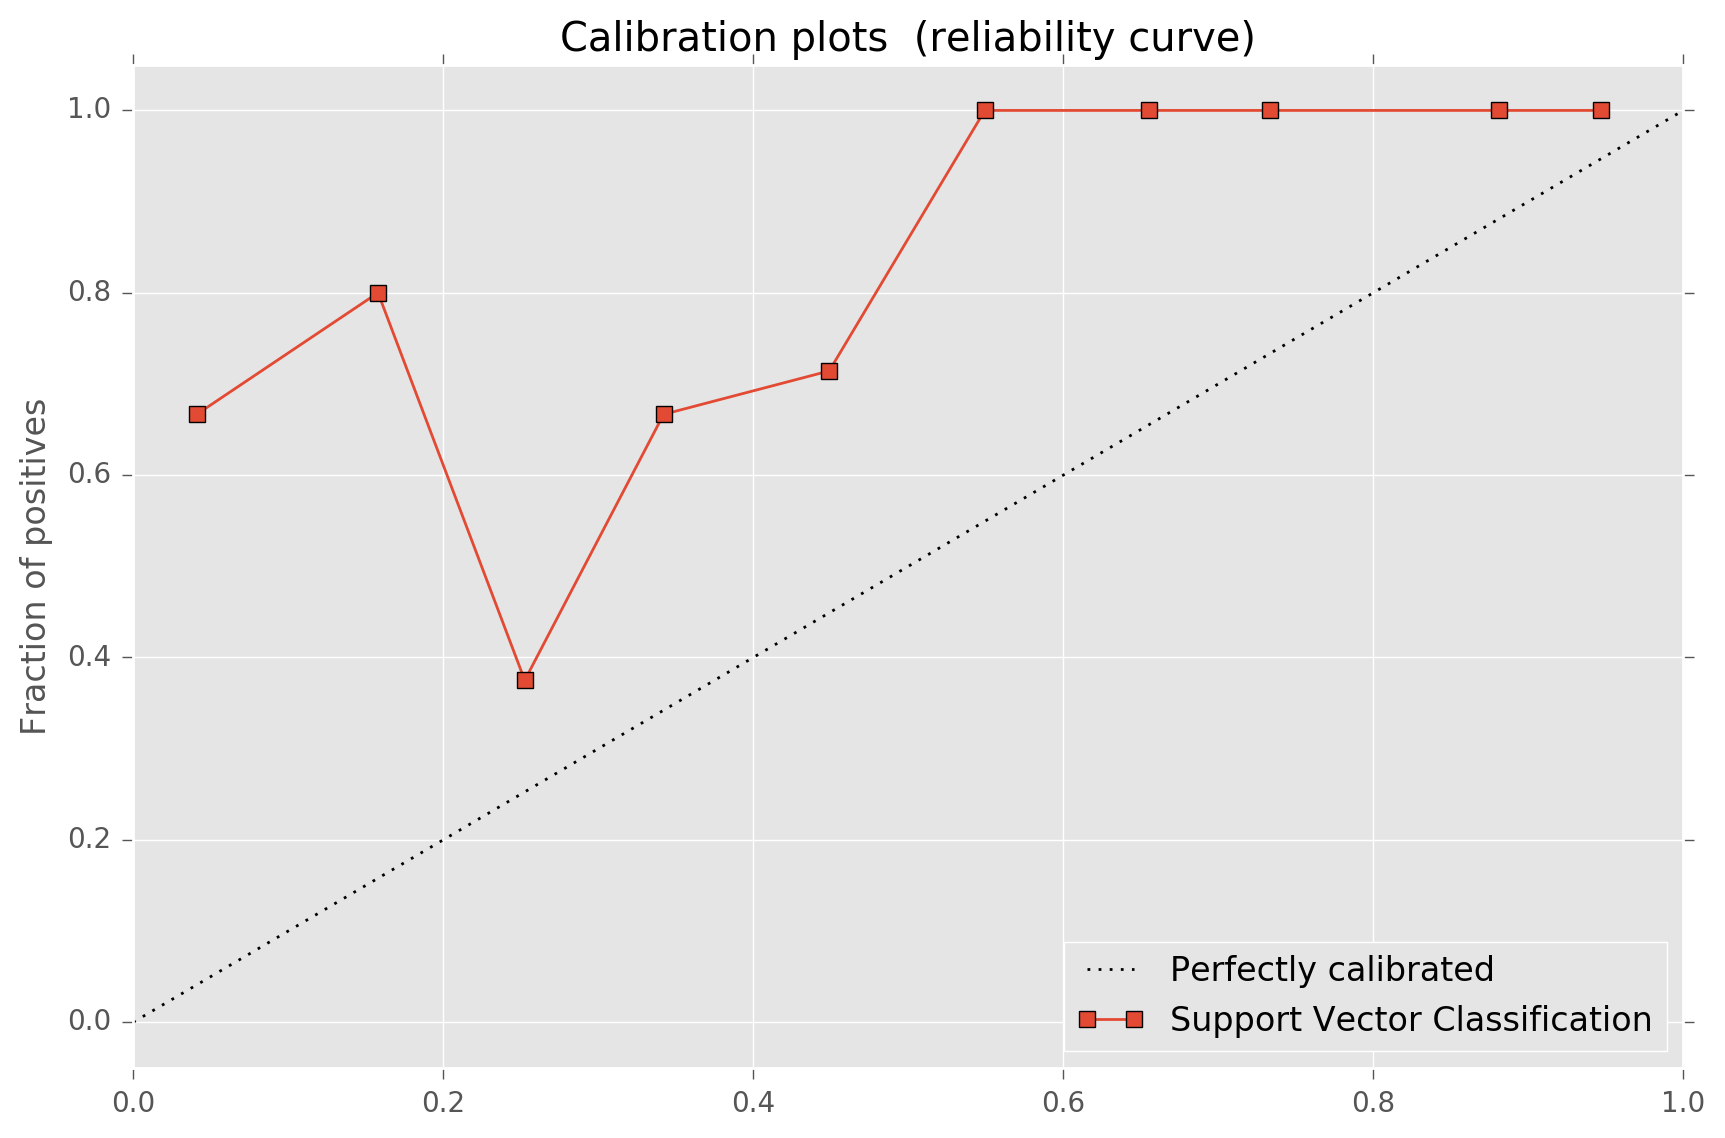

In [405]:
# Support Vector machine
BM.modelCheck(Xtrex, Xvalex, ytrex, yvalex, svc)

ROC_AUC score is 0.558441558442


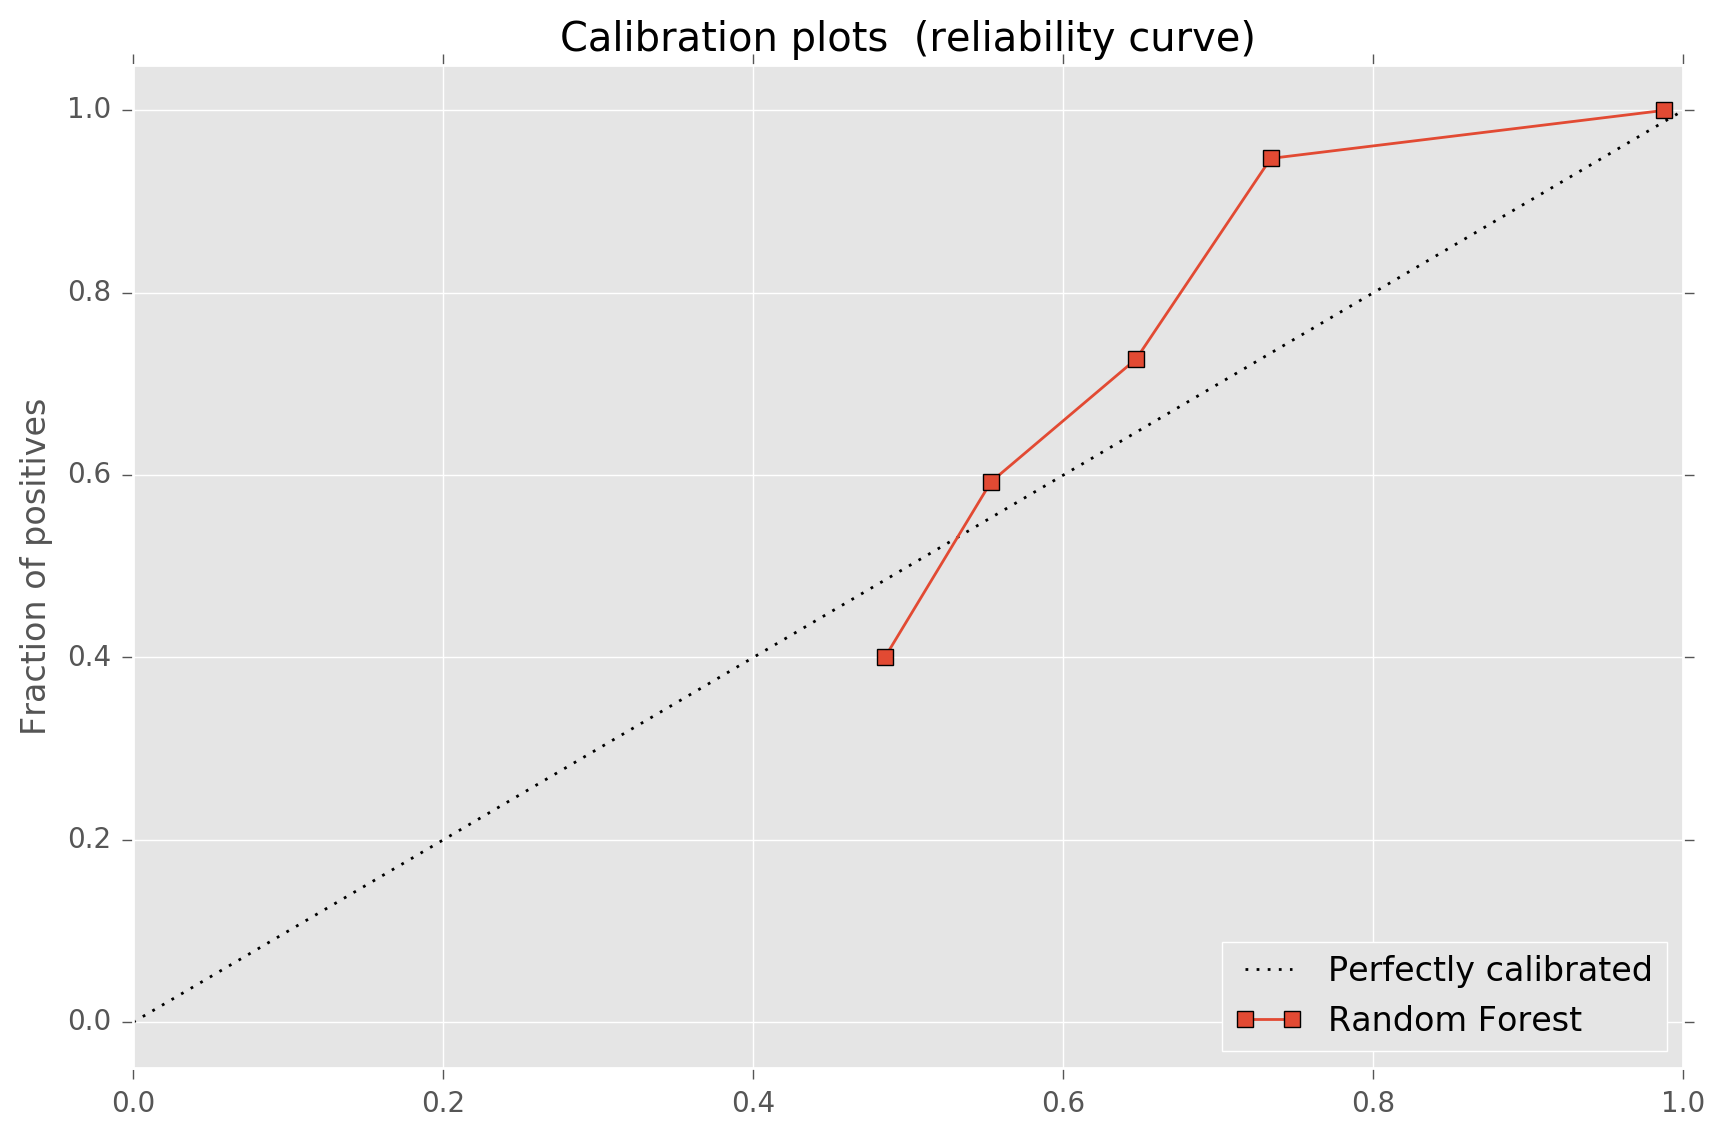

In [481]:
# Random Forest
BM.modelCheck(Xtrex, Xvalex, ytrex, yvalex, rfc)